In [1]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/')

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from utils.preprocessing import log_transform
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.optimize as opt
import warnings

warnings.filterwarnings("ignore")

In [2]:
''' We have 10 points of Analyte1 data, Analyte2 data and Analyte3 data respectively. '''

analyte1 = pd.read_csv('data/exponential/Exponential_Analyte1.csv').sort_values('CFU/mL', ascending=True).reset_index(drop=True)
analyte2 = pd.read_csv('data/exponential/Exponential_Analyte2.csv').sort_values('CFU/mL', ascending=True).reset_index(drop=True)
analyte3 = pd.read_csv('data/exponential/Exponential_Analyte3.csv').sort_values('CFU/mL', ascending=True).reset_index(drop=True)

# analyte1 = pd.read_csv('data/Sampled_Analyte1.csv').sort_values('CFU/mL', ascending=True).reset_index(drop=True)
# analyte2 = pd.read_csv('data/Sampled_Analyte2.csv').sort_values('CFU/mL', ascending=True).reset_index(drop=True)
# analyte3 = pd.read_csv('data/Sampled_Analyte3.csv').sort_values('CFU/mL', ascending=True).reset_index(drop=True)

[analyte1, analyte2, analyte3]  = log_transform([analyte1, analyte2, analyte3])
analyte1['Label'] = 0
analyte2['Label'] = 1
analyte3['Label'] = 2

combined_data = pd.concat([analyte1, analyte2, analyte3], axis=0)
combined_data = combined_data.sample(frac=1).reset_index(drop=True)

data = combined_data[['Sensor1','Sensor2','Sensor3','Label']]
data.head(3)

,Sensor1,Sensor2,Sensor3,Label
0,130.841794,-58.222957,40.931907,2
1,-96.462490,39.681875,24.926342,0
2,108.923581,-52.944250,74.580507,2


In [3]:
features = data[['Sensor1', 'Sensor2', 'Sensor3']]
labels = data['Label']

# scaler = StandardScaler()
# features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

kmeans_original = KMeans(n_clusters=3, random_state=42)
kmeans_original.fit(features)
data['Cluster_Original'] = kmeans_original.labels_

features.head(3)

,Sensor1,Sensor2,Sensor3
0,130.841794,-58.222957,40.931907
1,-96.462490,39.681875,24.926342
2,108.923581,-52.944250,74.580507


In [4]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

kmeans_pca = KMeans(n_clusters=3, random_state=42)
kmeans_pca.fit(pca_features)
data['Cluster_PCA'] = kmeans_pca.labels_

In [5]:
comparison_original = pd.crosstab(data['Label'], data['Cluster_Original'], rownames=['Actual'], colnames=['Cluster'])
print("Comparison for Original Data:")
print(comparison_original)

comparison_pca = pd.crosstab(data['Label'], data['Cluster_PCA'], rownames=['Actual'], colnames=['Cluster'])
print("\nComparison for PCA-Transformed Data:")
print(comparison_pca)

Comparison for Original Data:
Cluster     0    1     2
Actual                  
0           0    0  1022
1           0  752   270
2        1022    0     0

Comparison for PCA-Transformed Data:
Cluster     0    1     2
Actual                  
0           0    0  1022
1           0  762   260
2        1022    0     0


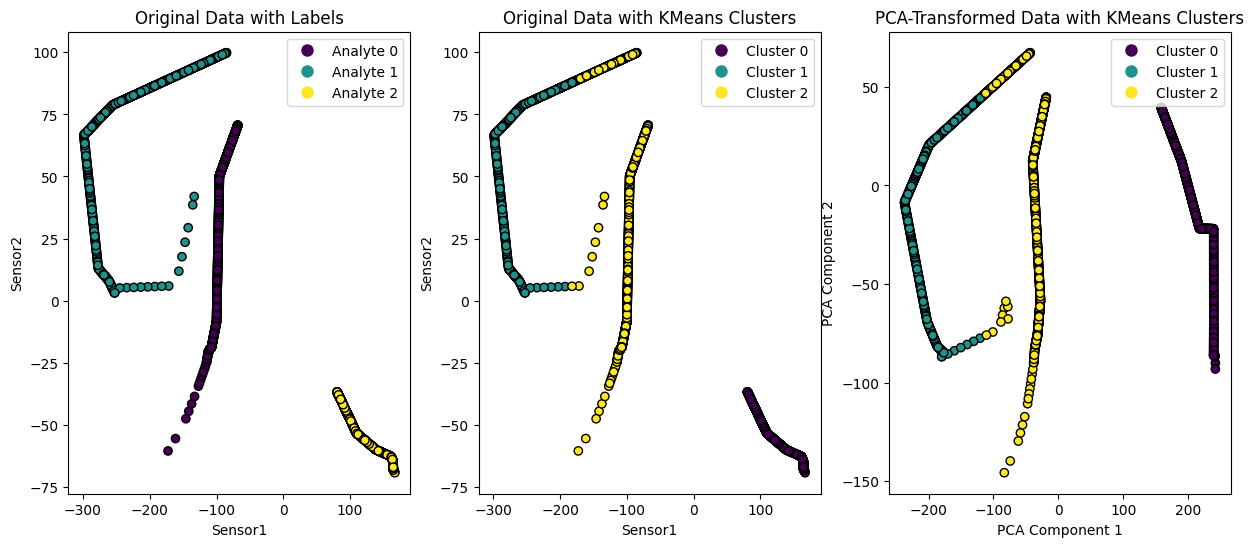

In [6]:

# Optionally, visualize the PCA-transformed data and clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot labels
plt.subplot(1, 3, 1)
plt.scatter(features['Sensor1'], features['Sensor2'], c=data['Label'], cmap='viridis', marker='o', edgecolor='k')
plt.title('Original Data with Labels')
plt.xlabel('Sensor1')
plt.ylabel('Sensor2')

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = np.unique(data['Label'])
for i in unique_labels:
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / 2), markersize=10))
    labels.append(f'Analyte {i}')

plt.legend(handles, labels)


# Plot original data clusters
plt.subplot(1, 3, 2)
plt.scatter(features['Sensor1'], features['Sensor2'], c=data['Cluster_Original'], cmap='viridis', marker='o', edgecolor='k')
plt.title('Original Data with KMeans Clusters')
plt.xlabel('Sensor1')
plt.ylabel('Sensor2')

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = np.unique(data['Cluster_Original'])
for i in unique_labels:
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / 2), markersize=10))
    labels.append(f'Cluster {i}')

plt.legend(handles, labels)


# Plot PCA-transformed data clusters
plt.subplot(1, 3, 3)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=data['Cluster_PCA'], cmap='viridis', marker='o', edgecolor='k')
plt.title('PCA-Transformed Data with KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = np.unique(data['Cluster_PCA'])
for i in unique_labels:
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / 2), markersize=10))
    labels.append(f'Cluster {i}')

plt.legend(handles, labels)

plt.savefig('docs/plots/exponential_kmeans/Original_vs_PCA.png')

plt.show()

In [7]:
print(data['Label'].value_counts())

print(data['Cluster_Original'].value_counts())

print(data['Cluster_PCA'].value_counts())

Label
2    1022
0    1022
1    1022
Name: count, dtype: int64
Cluster_Original
2    1292
0    1022
1     752
Name: count, dtype: int64
Cluster_PCA
2    1282
0    1022
1     762
Name: count, dtype: int64
